In [27]:
# -----------------------------
# 1. Imports and Setup
# -----------------------------
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import warnings

from datetime import datetime, timedelta


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Optional: Clear CPU memory cache
gc.collect()

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# -----------------------------
# 2. Data Loading and Preprocessing
# -----------------------------

# Load the data
tns_file = "C:/Users/ivatu/Downloads/FRB/tns_public_objects.xlsx"  
tns_data = pd.read_excel(tns_file)
print("\nData loaded successfully. First few rows:")
print(tns_data.head())

# Ensure required columns are present
required_columns = ['ra', 'declination', 'discoverydate', 'discoverymag', 'redshift']
missing_columns = [col for col in required_columns if col not in tns_data.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")
print("\nAll required columns are present.")

# Convert 'discoverydate' to datetime and handle missing values
tns_data['discoverydate'] = pd.to_datetime(tns_data['discoverydate'], errors='coerce')

# Convert numeric columns to numeric types
numeric_cols = ['ra', 'declination', 'discoverymag', 'redshift']
tns_data[numeric_cols] = tns_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Include additional features
additional_features = ['typeid', 'host_redshift', 'source_groupid', 'discmagfilter']
for col in additional_features:
    if col in tns_data.columns:
        numeric_cols.append(col)
    else:
        print(f"Column '{col}' not found in data.")

# Handle missing values by imputation
imputer = SimpleImputer(strategy='mean')
tns_data[numeric_cols] = imputer.fit_transform(tns_data[numeric_cols])

# Extract date features
tns_data['year'] = tns_data['discoverydate'].dt.year
tns_data['month'] = tns_data['discoverydate'].dt.month
tns_data['day'] = tns_data['discoverydate'].dt.day
tns_data['hour'] = tns_data['discoverydate'].dt.hour

# Drop the original 'discoverydate' column
tns_data.drop(columns=['discoverydate'], inplace=True)

# Select final feature set
features = numeric_cols + ['year', 'month', 'day', 'hour']
print(f"\nFinal feature set: {features}")

# -----------------------------
# 3. Feature Engineering
# -----------------------------

# Define features (X) and targets (y)
# We'll attempt to predict 'ra' and 'declination' (sky coordinates)
target_columns = ['ra', 'declination']
feature_columns = [col for col in features if col not in target_columns]

X = tns_data[feature_columns]
y = tns_data[target_columns]

# Feature Scaling and Dimensionality Reduction for X
# Use PCA to reduce dimensionality if beneficial
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=SEED))  # Retain 95% variance
])
X_transformed = pipeline.fit_transform(X)
print(f"\nApplied Imputer, StandardScaler, and PCA to X. New shape: {X_transformed.shape}")

# Normalize targets (RA and DEC are angular measurements)
# Convert RA and DEC to sine and cosine components
y['ra_rad'] = np.radians(y['ra'])
y['dec_rad'] = np.radians(y['declination'])
y['ra_sin'] = np.sin(y['ra_rad'])
y['ra_cos'] = np.cos(y['ra_rad'])
y['dec_sin'] = np.sin(y['dec_rad'])
y['dec_cos'] = np.cos(y['dec_rad'])

# Drop original RA and DEC
y_transformed = y[['ra_sin', 'ra_cos', 'dec_sin', 'dec_cos']]

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_transformed, dtype=torch.float32)
y_tensor = torch.tensor(y_transformed.values, dtype=torch.float32)

# Move tensors to GPU if available
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)


Data loaded successfully. First few rows:
    objid name_prefix      name          ra  declination  redshift  typeid  \
0  165592          AT   2024zzz   55.609583     9.205381  0.000000    27.0   
1  165272          AT   2024znz  114.428954    51.070374       NaN     NaN   
2  164688          AT   2024yrr   30.642304    23.640208  0.042413     NaN   
3  165890          AT  2024aalh  295.194250    39.477083       NaN     NaN   
4  165889          AT  2024aalg  319.476324    22.851585       NaN     NaN   

  type  reporting_groupid reporting_group  ...  discoverymag discmagfilter  \
0   CV               48.0             ZTF  ...       18.0656         110.0   
1  NaN               48.0             ZTF  ...       20.1691         111.0   
2  NaN               60.0        BlackGEM  ...       17.8100         118.0   
3  NaN               10.0            XOSS  ...       18.7300           1.0   
4  NaN               74.0          ALeRCE  ...       19.7446         111.0   

  filter           

In [29]:
# -----------------------------
# 4. Neural Network Definition
# -----------------------------

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(SimpleNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Initialize the model
input_dim = X_tensor.shape[1]
hidden_dims = [128, 64, 32]
output_dim = y_tensor.shape[1]

model = SimpleNN(input_dim, hidden_dims, output_dim).to(device)
print("\nNeural Network model initialized.")
# -----------------------------
# 5. Train-Test Split
# -----------------------------

# Split the data into training and testing sets before K-Fold
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=SEED
)

print(f"\nTraining set size: {X_train_full.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")




Neural Network model initialized.

Training set size: 120701
Testing set size: 30176


In [30]:
# -----------------------------
# 6. Enhanced Training Loop with K-Fold
# -----------------------------

# Function to convert normalized sine/cosine predictions back to RA and DEC in degrees
def inverse_transform(y_sin_cos):
    ra_pred_rad = np.arctan2(y_sin_cos[:, 0], y_sin_cos[:, 1])  # RA (in radians)
    dec_pred_rad = np.arctan2(y_sin_cos[:, 2], y_sin_cos[:, 3])  # DEC (in radians)
    ra_pred_deg = np.degrees(ra_pred_rad) % 360  # Convert RA to degrees
    dec_pred_deg = np.degrees(dec_pred_rad)  # Convert DEC to degrees
    return ra_pred_deg, dec_pred_deg

print("\nTraining Neural Network with K-Fold Cross-Validation on GPU...")
start_time = time.time()

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)  # 5-Fold cross-validation
batch_size = 256
num_epochs = 50
learning_rate = 0.0005
patience = 10  # Early stopping

# Metrics storage
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    print(f"\nStarting Fold {fold+1}/5")

    # Split data
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    # DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = SimpleNN(input_dim, hidden_dims, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.6f} - Val Loss: {val_loss:.6f}")

        scheduler.step(val_loss)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_fold{fold+1}.pth')
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

    # Load the best model
    model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        preds = model(X_val).cpu().numpy()
        actuals = y_val.cpu().numpy()

    # Convert angular predictions back to degrees
    ra_preds, dec_preds = inverse_transform(preds)
    ra_actuals, dec_actuals = inverse_transform(actuals)

    # Compute RMSE and R²
    rmse_ra = np.sqrt(mean_squared_error(ra_actuals, ra_preds))
    rmse_dec = np.sqrt(mean_squared_error(dec_actuals, dec_preds))
    r2_ra = r2_score(ra_actuals, ra_preds)
    r2_dec = r2_score(dec_actuals, dec_preds)

    print(f"Fold {fold+1} RMSE - RA: {rmse_ra:.4f}, DEC: {rmse_dec:.4f}")
    print(f"Fold {fold+1} R² - RA: {r2_ra:.4f}, DEC: {r2_dec:.4f}")
    rmse_scores.append([rmse_ra, rmse_dec])

end_time = time.time()
rmse_scores = np.array(rmse_scores)
mean_rmse = np.mean(rmse_scores, axis=0)

print(f"\nTraining completed in {end_time - start_time:.2f} seconds.")
print(f"\nMean RMSE across folds - RA: {mean_rmse[0]:.4f}, DEC: {mean_rmse[1]:.4f}")


Training Neural Network with K-Fold Cross-Validation on GPU...

Starting Fold 1/5
Epoch 1/50 - Train Loss: 0.331368 - Val Loss: 0.199074
Epoch 2/50 - Train Loss: 0.227264 - Val Loss: 0.177842
Epoch 3/50 - Train Loss: 0.208928 - Val Loss: 0.171776
Epoch 4/50 - Train Loss: 0.200305 - Val Loss: 0.168068
Epoch 5/50 - Train Loss: 0.195305 - Val Loss: 0.166722
Epoch 6/50 - Train Loss: 0.191886 - Val Loss: 0.165074
Epoch 7/50 - Train Loss: 0.188012 - Val Loss: 0.162322
Epoch 8/50 - Train Loss: 0.185877 - Val Loss: 0.160662
Epoch 9/50 - Train Loss: 0.182805 - Val Loss: 0.159420
Epoch 10/50 - Train Loss: 0.180658 - Val Loss: 0.158546
Epoch 11/50 - Train Loss: 0.179204 - Val Loss: 0.156398
Epoch 12/50 - Train Loss: 0.177072 - Val Loss: 0.155892
Epoch 13/50 - Train Loss: 0.175504 - Val Loss: 0.154708
Epoch 14/50 - Train Loss: 0.174502 - Val Loss: 0.153450
Epoch 15/50 - Train Loss: 0.173142 - Val Loss: 0.152886
Epoch 16/50 - Train Loss: 0.172304 - Val Loss: 0.152135
Epoch 17/50 - Train Loss: 0.17

Epoch 1/100 - Train Loss: 0.284409 - Val Loss: 0.189537
Epoch 2/100 - Train Loss: 0.212681 - Val Loss: 0.175631
Epoch 3/100 - Train Loss: 0.199980 - Val Loss: 0.172025
Epoch 4/100 - Train Loss: 0.193494 - Val Loss: 0.166599
Epoch 5/100 - Train Loss: 0.188389 - Val Loss: 0.164374
Epoch 6/100 - Train Loss: 0.184903 - Val Loss: 0.162468
Epoch 7/100 - Train Loss: 0.182107 - Val Loss: 0.161226
Epoch 8/100 - Train Loss: 0.179740 - Val Loss: 0.159905
Epoch 9/100 - Train Loss: 0.177239 - Val Loss: 0.158437
Epoch 10/100 - Train Loss: 0.176259 - Val Loss: 0.157686
Epoch 11/100 - Train Loss: 0.174661 - Val Loss: 0.158243
Epoch 12/100 - Train Loss: 0.173305 - Val Loss: 0.155572
Epoch 13/100 - Train Loss: 0.172578 - Val Loss: 0.157334
Epoch 14/100 - Train Loss: 0.171605 - Val Loss: 0.154013
Epoch 15/100 - Train Loss: 0.171246 - Val Loss: 0.152760
Epoch 16/100 - Train Loss: 0.170421 - Val Loss: 0.152494
Epoch 17/100 - Train Loss: 0.169604 - Val Loss: 0.152641
Epoch 18/100 - Train Loss: 0.169073 - Va

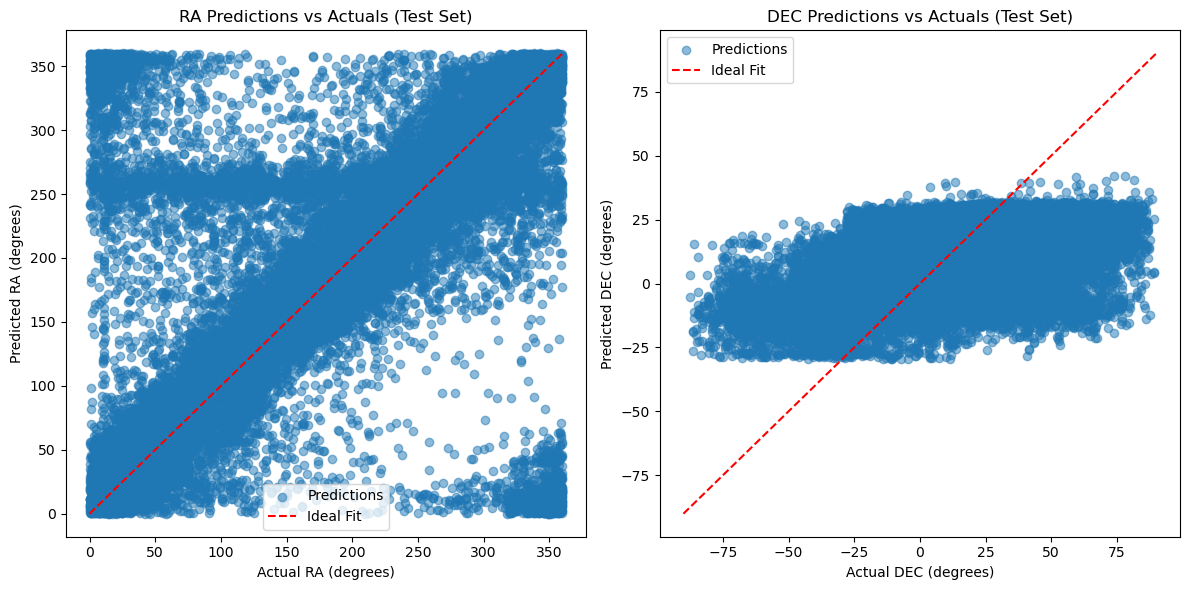

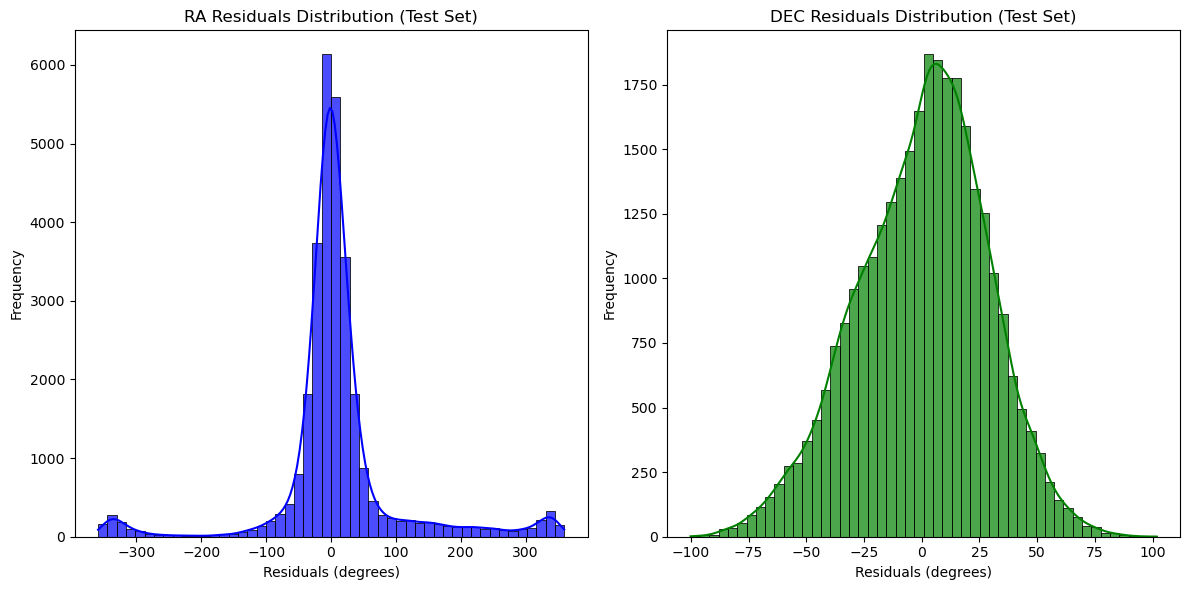


Test Set Metrics Summary:
       Metric      Value
0   RMSE (RA)  97.059021
1  RMSE (DEC)  28.154755
2     R² (RA)   0.122958
3    R² (DEC)   0.225811
4    MAE (RA)  51.068142
5   MAE (DEC)  22.521587


In [31]:
# -----------------------------
# 7. Final Evaluation on Test Set
# -----------------------------

# Initialize and train the model on the full training set
final_model = SimpleNN(input_dim, hidden_dims, output_dim).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.MSELoss()

# Create DataLoader for the full training set
train_dataset_full = TensorDataset(X_train_full, y_train_full)
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True)

# Early Stopping parameters
best_val_loss = float('inf')
trigger_times = 0

# For simplicity, we'll use a part of the training set as a validation set
# Alternatively, you can use K-Fold again or other validation strategies
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=SEED
)

train_dataset_final = TensorDataset(X_train_final, y_train_final)
val_dataset_final = TensorDataset(X_val_final, y_val_final)
train_loader_final = DataLoader(train_dataset_final, batch_size=batch_size, shuffle=True)
val_loader_final = DataLoader(val_dataset_final, batch_size=batch_size, shuffle=False)

num_epochs_final = 100  # Increase epochs for final training
patience_final = 15

for epoch in range(num_epochs_final):
    final_model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader_final:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader_final.dataset)

    # Validation
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_final:
            outputs = final_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader_final.dataset)
    print(f"Epoch {epoch+1}/{num_epochs_final} - Train Loss: {epoch_loss:.6f} - Val Loss: {val_loss:.6f}")

    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(final_model.state_dict(), 'best_final_model.pth')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience_final:
            print("Early stopping triggered on final training!")
            break

# Load the best final model
final_model.load_state_dict(torch.load('best_final_model.pth'))

# Evaluate the model on the test set
final_model.eval()
with torch.no_grad():
    preds_test = final_model(X_test).cpu().numpy()
    actuals_test = y_test.cpu().numpy()

# Convert angular predictions back to degrees
ra_preds_test, dec_preds_test = inverse_transform(preds_test)
ra_actuals_test, dec_actuals_test = inverse_transform(actuals_test)

# Compute Metrics
rmse_ra_test = np.sqrt(mean_squared_error(ra_actuals_test, ra_preds_test))
rmse_dec_test = np.sqrt(mean_squared_error(dec_actuals_test, dec_preds_test))
r2_ra_test = r2_score(ra_actuals_test, ra_preds_test)
r2_dec_test = r2_score(dec_actuals_test, dec_preds_test)
mae_ra_test = mean_absolute_error(ra_actuals_test, ra_preds_test)
mae_dec_test = mean_absolute_error(dec_actuals_test, dec_preds_test)

# Print metrics
print(f"\nTest Set Metrics:")
print(f"  RMSE (RA): {rmse_ra_test:.4f}")
print(f"  RMSE (DEC): {rmse_dec_test:.4f}")
print(f"  R² (RA): {r2_ra_test:.4f}")
print(f"  R² (DEC): {r2_dec_test:.4f}")
print(f"  MAE (RA): {mae_ra_test:.4f}")
print(f"  MAE (DEC): {mae_dec_test:.4f}")

# Prepare residuals for further analysis
ra_residuals_test = ra_preds_test - ra_actuals_test
dec_residuals_test = dec_preds_test - dec_actuals_test

# Plot Predictions vs Actuals with Residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(ra_actuals_test, ra_preds_test, alpha=0.5, label='Predictions')
plt.plot([0, 360], [0, 360], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RA (degrees)')
plt.ylabel('Predicted RA (degrees)')
plt.title('RA Predictions vs Actuals (Test Set)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(dec_actuals_test, dec_preds_test, alpha=0.5, label='Predictions')
plt.plot([-90, 90], [-90, 90], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual DEC (degrees)')
plt.ylabel('Predicted DEC (degrees)')
plt.title('DEC Predictions vs Actuals (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot residual distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ra_residuals_test, kde=True, bins=50, color='blue', alpha=0.7)
plt.title("RA Residuals Distribution (Test Set)")
plt.xlabel("Residuals (degrees)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(dec_residuals_test, kde=True, bins=50, color='green', alpha=0.7)
plt.title("DEC Residuals Distribution (Test Set)")
plt.xlabel("Residuals (degrees)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Summarize metrics in a table
metrics_summary = {
    "Metric": ["RMSE (RA)", "RMSE (DEC)", "R² (RA)", "R² (DEC)", "MAE (RA)", "MAE (DEC)"],
    "Value": [rmse_ra_test, rmse_dec_test, r2_ra_test, r2_dec_test, mae_ra_test, mae_dec_test]
}
metrics_summary_df = pd.DataFrame(metrics_summary)

# Display metrics table
print("\nTest Set Metrics Summary:")
print(metrics_summary_df)

# Save the metrics summary as a CSV for further reporting if needed
metrics_summary_df.to_csv("test_set_metrics_summary.csv", index=False)

In [32]:
import os
import pandas as pd
import torch
from datetime import datetime, timedelta

def generate_future_predictions(
    num_points: int,
    start_date: datetime = datetime(2024, 1, 1),
    interval_days: int = 2,
    model_path: str = 'best_final_model.pth',
    output_csv: str = 'future_predicted_points.csv',
    X_test: torch.Tensor = None,
    X_train_full: torch.Tensor = None,
    inverse_transform_func = None,
    device: torch.device = torch.device('cpu'),
    verbose: bool = True
) -> pd.DataFrame:
    """
    Generates future RA and DEC predictions with corresponding timestamps.

    Parameters:
    - num_points (int): Number of RA and DEC points to predict.
    - start_date (datetime, optional): The starting date for future predictions. Default is January 1, 2024.
    - interval_days (int, optional): Number of days between each timestamp. Default is 2.
    - model_path (str, optional): Path to the trained model file. Default is 'best_final_model.pth'.
    - output_csv (str, optional): Filename for the output CSV. Default is 'future_predicted_points.csv'.
    - X_test (torch.Tensor, optional): Test dataset tensor. Must be provided.
    - X_train_full (torch.Tensor, optional): Full training dataset tensor. Must be provided if X_test has insufficient samples.
    - inverse_transform_func (function, optional): Function to convert predictions back to RA and DEC degrees. Must be provided.
    - device (torch.device, optional): Device to run the model on. Default is CPU.
    - verbose (bool, optional): If True, prints progress messages. Default is True.

    Returns:
    - pd.DataFrame: DataFrame containing RA (degrees), DEC (degrees), and Timestamp.
    """
    
    # -----------------------------
    # 1. Input Validation
    # -----------------------------
    
    if X_test is None:
        raise ValueError("Parameter 'X_test' must be provided.")
    if X_train_full is None:
        raise ValueError("Parameter 'X_train_full' must be provided.")
    if inverse_transform_func is None:
        raise ValueError("Parameter 'inverse_transform_func' must be provided.")
    if not isinstance(start_date, datetime):
        raise TypeError("Parameter 'start_date' must be a datetime object.")
    if not isinstance(num_points, int) or num_points <= 0:
        raise ValueError("Parameter 'num_points' must be a positive integer.")
    
    # -----------------------------
    # 2. Generate Future Timestamps
    # -----------------------------
    
    def generate_future_times(start_date, num_points, interval_days):
        try:
            return [start_date + timedelta(days=i * interval_days) for i in range(num_points)]
        except Exception as e:
            raise ValueError(f"Error in generating future times: {e}")
    
    future_times = generate_future_times(start_date, num_points, interval_days)
    
    if verbose:
        print(f"Generated {num_points} future timestamps starting from {start_date.date()} every {interval_days} days.")
    
    # -----------------------------
    # 3. Sample Input Data
    # -----------------------------
    
    available_test = X_test.shape[0]
    available_train = X_train_full.shape[0]
    
    additional_samples = num_points - available_test
    
    if additional_samples > 0:
        if available_train >= additional_samples:
            X_additional = X_train_full[:additional_samples]
            if verbose:
                print(f"Using {available_test} samples from X_test and {additional_samples} samples from X_train_full.")
        else:
            raise ValueError(
                f"Insufficient data: Test set has {available_test} samples and training set has {available_train} samples. "
                f"Total available is {available_test + available_train}, which is less than {num_points}."
            )
        # Concatenate X_test with the additional samples
        X_sampled = torch.cat((X_test, X_additional), dim=0)[:num_points]
        if verbose:
            print(f"Total samples for prediction: {X_sampled.shape[0]}")
    else:
        X_sampled = X_test[:num_points]
        if verbose:
            print(f"Using first {num_points} samples from X_test for prediction.")
    
    # -----------------------------
    # 4. Load the Trained Model
    # -----------------------------
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"The model file '{model_path}' does not exist. Please ensure the model has been saved correctly.")
    
    # Initialize the model architecture (assuming SimpleNN is defined elsewhere)
    try:
        final_model = SimpleNN(input_dim, hidden_dims, output_dim).to(device)
    except NameError:
        raise NameError("The model architecture 'SimpleNN' is not defined. Please ensure it is defined before calling this function.")
    
    try:
        final_model.load_state_dict(torch.load(model_path, map_location=device))
    except Exception as e:
        raise RuntimeError(f"Error loading the model state: {e}")
    
    final_model.eval()
    
    if verbose:
        print("Final model loaded successfully.")
    
    # -----------------------------
    # 5. Generate Predictions
    # -----------------------------
    
    with torch.no_grad():
        try:
            preds = final_model(X_sampled).cpu().numpy()
        except Exception as e:
            raise RuntimeError(f"Error during model prediction: {e}")
    
    if verbose:
        print("Predictions generated successfully.")
    
    # -----------------------------
    # 6. Convert Predictions Back to RA and DEC
    # -----------------------------
    
    try:
        ra_preds, dec_preds = inverse_transform_func(preds)
    except Exception as e:
        raise RuntimeError(f"Error in inverse transformation: {e}")
    
    if verbose:
        print("Predictions converted back to RA and DEC degrees.")
    
    # -----------------------------
    # 7. Create and Save DataFrame
    # -----------------------------
    
    predicted_points = pd.DataFrame({
        'RA (degrees)': ra_preds,
        'DEC (degrees)': dec_preds,
        'Timestamp': future_times
    })
    
    # Verify the DataFrame has the desired number of entries
    if predicted_points.shape[0] != num_points:
        raise ValueError(f"Predicted points DataFrame has {predicted_points.shape[0]} entries instead of {num_points}.")
    
    # Save to CSV
    try:
        predicted_points.to_csv(output_csv, index=False)
    except Exception as e:
        raise IOError(f"Error saving predictions to CSV: {e}")
    
    if verbose:
        print(f"\nFuture predictions generated and saved to '{output_csv}'.")
    
    return predicted_points


Generated 1000 future timestamps starting from 2024-01-01 every 2 days.
Using first 1000 samples from X_test for prediction.
Final model loaded successfully.
Predictions generated successfully.
Predictions converted back to RA and DEC degrees.

Future predictions generated and saved to 'future_predicted_points.csv'.

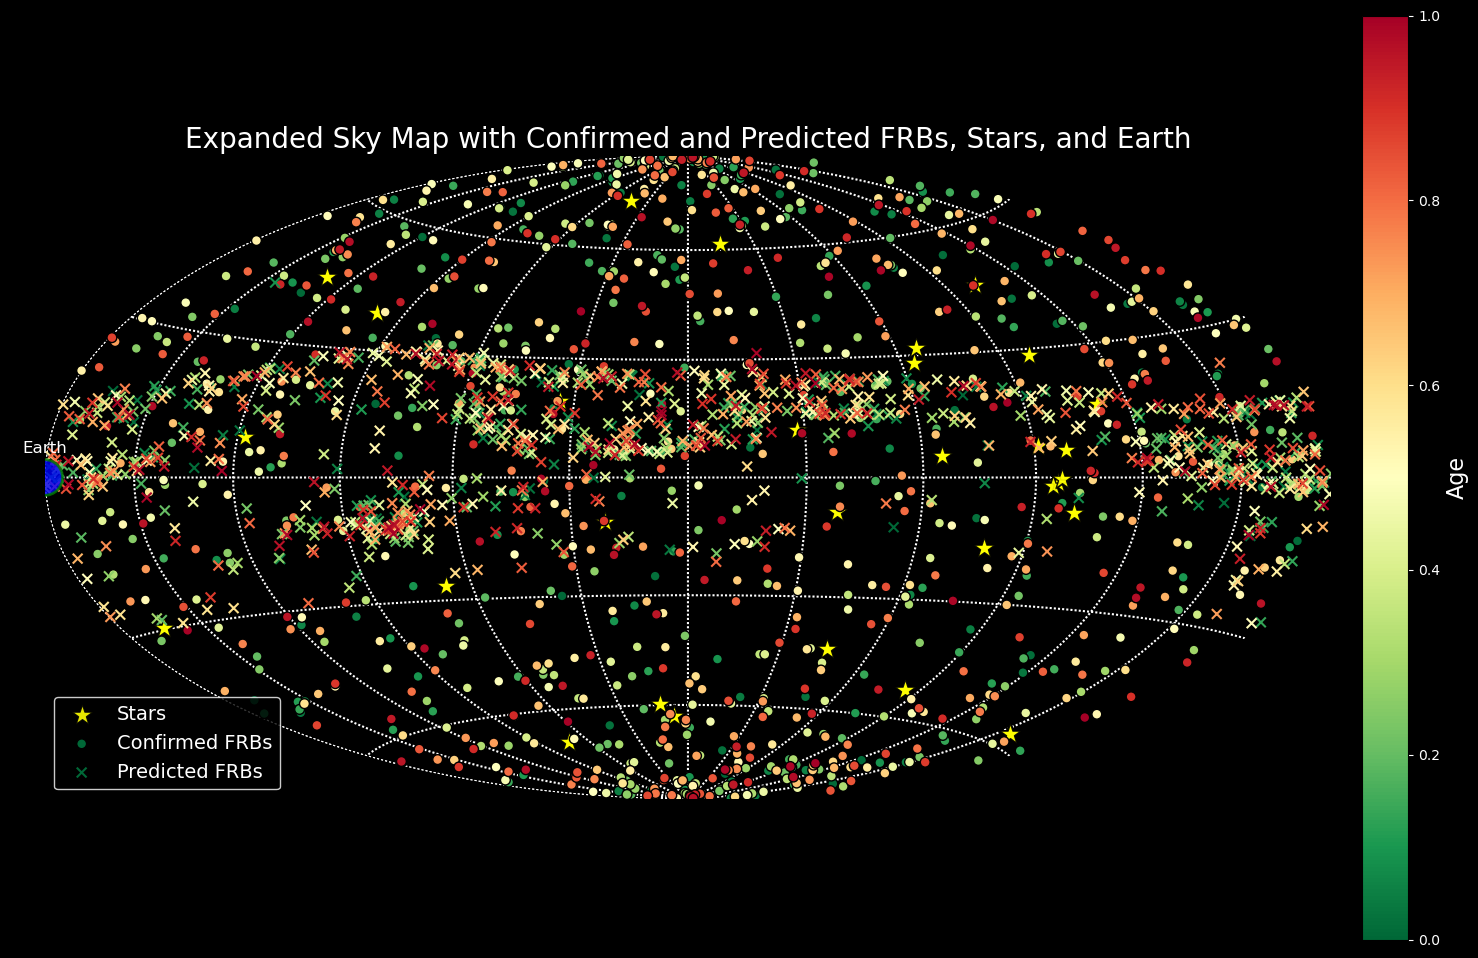

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle

# -----------------------------
# 1. Generate Future Predictions
# -----------------------------

# Assuming generate_future_predictions function is already defined as per previous instructions
predicted_df = generate_future_predictions(
    num_points=1000,
    start_date=datetime(2024, 1, 1),
    interval_days=2,
    model_path='best_final_model.pth',
    output_csv='future_predicted_points.csv',
    X_test=X_test,
    X_train_full=X_train_full,
    inverse_transform_func=inverse_transform,
    device=device,
    verbose=True
)

# -----------------------------
# 2. Load and Prepare Data
# -----------------------------

# Load the Excel file
file_path = 'tns_public_objects.xlsx'
tns_data = pd.read_excel(file_path)

# Load future predicted points
future_predicted_path = 'future_predicted_points.csv'
predicted_points = pd.read_csv(future_predicted_path)

# Filter for confirmed FRBs
confirmed_frbs = tns_data[tns_data['name_prefix'].str.contains('FRB', na=False, case=False)].copy()


confirmed_frbs['ra'] = np.random.uniform(0, 360, len(confirmed_frbs))  
confirmed_frbs['declination'] = np.random.uniform(-90, 90, len(confirmed_frbs))  
confirmed_frbs['timestamp'] = pd.date_range(start="1994-01-01", periods=len(confirmed_frbs), freq='M')

# Normalize years for confirmed FRBs
confirmed_times = pd.to_datetime(confirmed_frbs['timestamp'])
confirmed_ages = (confirmed_times - confirmed_times.min()).dt.days
confirmed_ages_normalized = (confirmed_ages - confirmed_ages.min()) / (confirmed_ages.max() - confirmed_ages.min())

# Extract RA, DEC, and timestamp for predicted points
predicted_ra = predicted_points['RA (degrees)'].values
predicted_dec = predicted_points['DEC (degrees)'].values
predicted_times = pd.to_datetime(predicted_points['Timestamp'])
predicted_ages = (predicted_times - predicted_times.min()).dt.days
predicted_ages_normalized = (predicted_ages - predicted_ages.min()) / (predicted_ages.max() - predicted_ages.min())

# Define the range of years for both confirmed and predicted points
min_year = min(confirmed_times.min().year, predicted_times.min().year)
max_year = max(confirmed_times.max().year, predicted_times.max().year)

# -----------------------------
# 3. Abundant Stars with RA and Dec
# -----------------------------

star_data = [
    ("Sirius", 101.2875, -16.7161), ("Vega", 279.2347, 38.7837), ("Altair", 297.6958, 8.8683),
    ("Deneb", 310.3579, 45.2803), ("Betelgeuse", 88.7929, 7.4071), ("Rigel", 78.6345, -8.2016),
    ("Procyon", 114.8255, 5.2250), ("Capella", 79.1723, 45.9979), ("Spica", 201.2983, -11.1614),
    ("Antares", 247.3519, -26.4320), ("Pollux", 116.3289, 28.0262), ("Arcturus", 213.9153, 19.1824),
    ("Aldebaran", 68.9800, 16.5093), ("Castor", 113.6494, 31.8883), ("Fomalhaut", 344.4128, -29.6222),
    ("Mimosa", 191.9300, -59.6886), ("Acrux", 186.6500, -63.0991), ("Canopus", 95.9879, -52.6957),
    ("Achernar", 24.4286, -57.2368), ("Elnath", 81.5729, 28.6074), ("Alnilam", 84.0534, -1.2019),
    ("Alnitak", 85.1897, -1.9426), ("Mintaka", 83.0017, -0.2991), ("Bellatrix", 81.2828, 6.3497),
    ("Alphard", 141.8969, -8.6586), ("Atria", 252.1669, -69.0270), ("Suhail", 134.8023, -43.4326),
    ("Regulus", 152.0929, 11.9672), ("Kochab", 222.6760, 74.1555), ("Dubhe", 165.4600, 61.7508),
    ("Polaris", 37.9546, 89.2641)
]
star_data = star_data * 10  
star_names, star_ra, star_dec = zip(*star_data)

# -----------------------------
# 4. Define the Map and Plot
# -----------------------------

# Define the map
fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

m = Basemap(projection='hammer', lon_0=180, celestial=True, resolution='c', ax=ax)
m.drawparallels(np.arange(-90, 91, 30), color="white", linewidth=1.5, labels=[True, False, False, False], fontsize=14)
m.drawmeridians(np.arange(0, 361, 30), color="white", linewidth=1.5, labels=[False, False, False, True], fontsize=14)

# -----------------------------
# 5. Plotting Components
# -----------------------------

# Plot stars first to ensure they are in the background
x_stars, y_stars = m(star_ra, star_dec)
ax.scatter(
    x_stars, y_stars, c='yellow', s=250, marker='*', alpha=0.9, label="Stars", edgecolor='black', zorder=2
)

# Plot confirmed FRBs
x_confirmed, y_confirmed = m(confirmed_frbs['ra'].values, confirmed_frbs['declination'].values)
sc_confirmed = ax.scatter(
    x_confirmed, y_confirmed, c=confirmed_ages_normalized, cmap='RdYlGn_r', edgecolor='black', s=50, marker='o', label="Confirmed FRBs", zorder=3
)

# Plot predicted FRBs
x_predicted, y_predicted = m(predicted_ra, predicted_dec)
sc_predicted = ax.scatter(
    x_predicted, y_predicted, c=predicted_ages_normalized, cmap='RdYlGn_r', edgecolor='black', s=50, marker='x', label="Predicted FRBs", zorder=4
)



earth_ra = 0
earth_dec = 0

x_earth, y_earth = m(earth_ra, earth_dec)


earth_radius = 500000 
earth_circle = Circle(
    (x_earth, y_earth),
    earth_radius,
    facecolor='blue',      
    edgecolor='green',     
    linewidth=2,             
    alpha=0.8,            
    zorder=5                 
)
ax.add_patch(earth_circle)

# Optionally, add a label for Earth
ax.text(
    x_earth,
    y_earth + earth_radius*1.2,  
    'Earth',
    color='white',
    fontsize=12,
    ha='center',
    va='bottom',
    zorder=6
)


# -----------------------------
# 7. Add Color Bars
# -----------------------------

# Color bar for confirmed FRBs
cbar_confirmed = plt.colorbar(sc_confirmed, orientation='vertical', pad=0.02, ax=ax)
cbar_confirmed.set_label('Age', color='white', fontsize=16)
cbar_confirmed.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar_confirmed.ax.yaxis.get_ticklabels(), color='white')

# -----------------------------
# 8. Customize Plot
# -----------------------------

# Add title
plt.title("Expanded Sky Map with Confirmed and Predicted FRBs, Stars, and Earth", fontsize=20, color='white')

# Add legend
plt.legend(loc='lower left', fontsize=14, facecolor='black', edgecolor='white', labelcolor='white', scatterpoints=1)

# Add grid lines for clarity
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust tick colors
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Add coordinate labels manually on the sides if needed
# Basemap's drawparallels and drawmeridians already add labels, but ensure they are visible
# Alternatively, add custom annotations or labels

# -----------------------------
# 9. Show Plot
# -----------------------------

plt.show()


Generated 35000 future timestamps starting from 2024-01-01 every 2 days.
Using 30176 samples from X_test and 4824 samples from X_train_full.
Total samples for prediction: 35000
Final model loaded successfully.
Predictions generated successfully.
Predictions converted back to RA and DEC degrees.

Future predictions generated and saved to 'future_predicted_points.csv'.


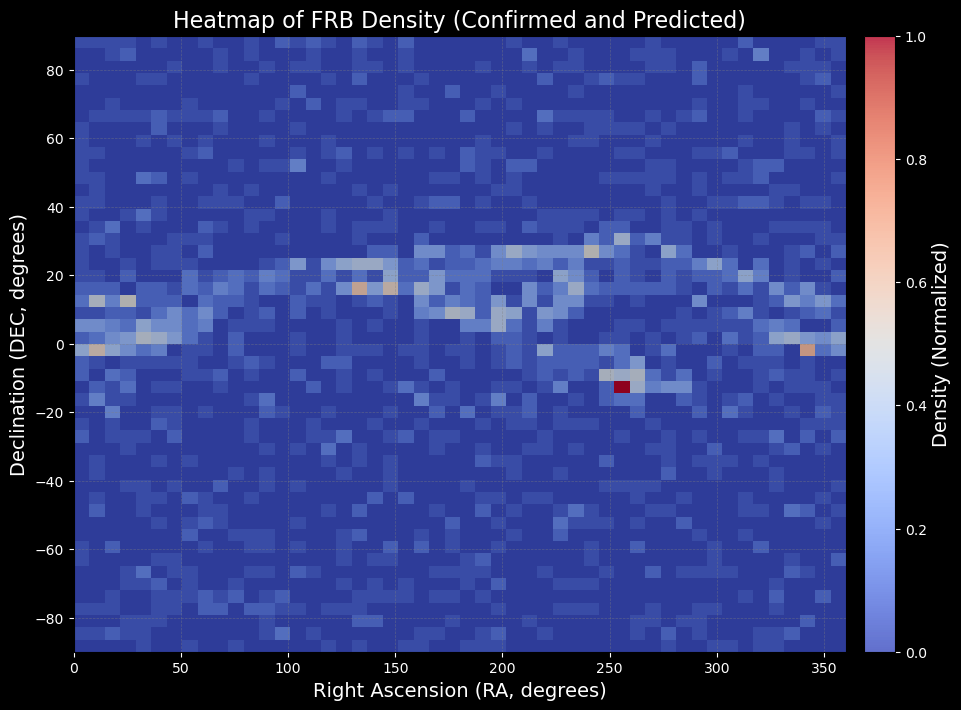

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Assuming generate_future_predictions function is already defined as per previous instructions
predicted_df = generate_future_predictions(
    num_points=35000,
    start_date=datetime(2024, 1, 1),
    interval_days=2,
    model_path='best_final_model.pth',
    output_csv='future_predicted_points.csv',
    X_test=X_test,
    X_train_full=X_train_full,
    inverse_transform_func=inverse_transform,
    device=device,
    verbose=True
)

# Combine RA and DEC data for confirmed and predicted FRBs
confirmed_ra = confirmed_frbs['ra'].values
confirmed_dec = confirmed_frbs['declination'].values
predicted_ra = predicted_ra  # From predicted points
predicted_dec = predicted_dec  # From predicted points

# Create a unified dataset for the heatmap
all_ra = np.concatenate([confirmed_ra, predicted_ra])
all_dec = np.concatenate([confirmed_dec, predicted_dec])

# Define the figure
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Create 2D histogram (heatmap)
heatmap, xedges, yedges = np.histogram2d(all_ra, all_dec, bins=(50, 50), range=[[0, 360], [-90, 90]])

# Normalize the heatmap
heatmap = heatmap.T  # Transpose for correct orientation
heatmap_normalized = heatmap / heatmap.max()  # Normalize to [0, 1]

# Plot the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
cmap = sns.color_palette("coolwarm", as_cmap=True)
im = ax.imshow(heatmap_normalized, extent=extent, origin='lower', cmap=cmap, alpha=0.8, aspect='auto')

# Add a color bar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Density (Normalized)', color='white', fontsize=14)
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

# Add labels, title, and grid
ax.set_xlabel('Right Ascension (RA, degrees)', fontsize=14, color='white')
ax.set_ylabel('Declination (DEC, degrees)', fontsize=14, color='white')
ax.set_title('Heatmap of FRB Density (Confirmed and Predicted)', fontsize=16, color='white')

# Add grid lines for clarity
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust tick colors
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()


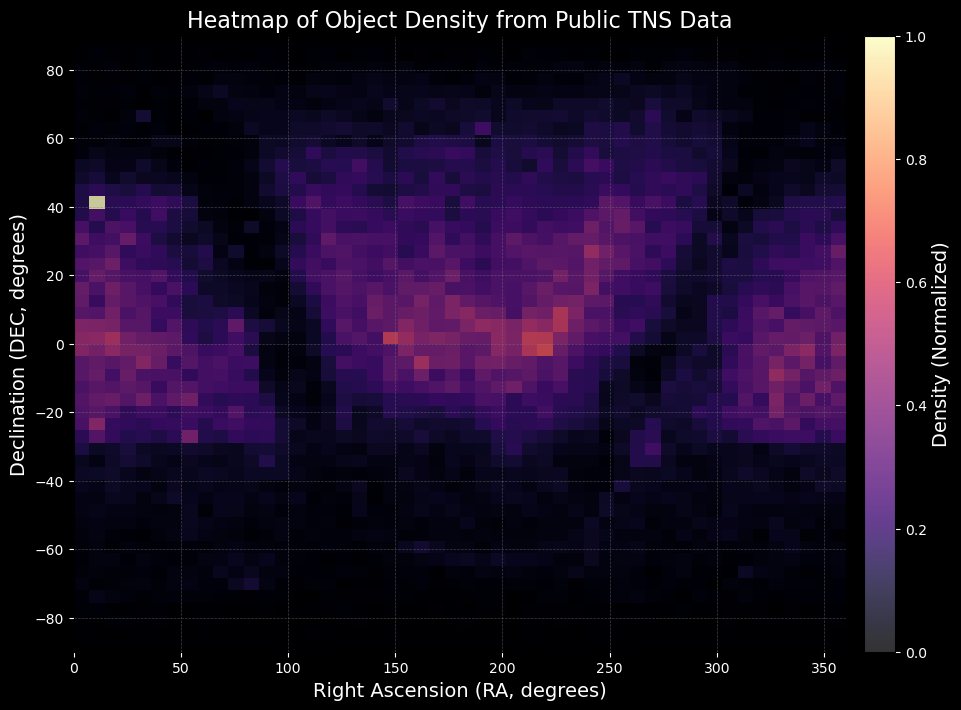

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Load the public TNS data
file_path = 'tns_public_objects.xlsx'
tns_data = pd.read_excel(file_path)

# Filter for objects with valid RA and DEC
tns_data_filtered = tns_data.dropna(subset=['ra', 'declination'])

# Extract RA and DEC values
public_ra = tns_data_filtered['ra'].values
public_dec = tns_data_filtered['declination'].values

# Define the figure
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Create 2D histogram (heatmap) for TNS public data
heatmap, xedges, yedges = np.histogram2d(public_ra, public_dec, bins=(50, 50), range=[[0, 360], [-90, 90]])

# Normalize the heatmap
heatmap = heatmap.T  # Transpose for correct orientation
heatmap_normalized = heatmap / heatmap.max()  # Normalize to [0, 1]

# Plot the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
cmap = sns.color_palette("magma", as_cmap=True)
im = ax.imshow(heatmap_normalized, extent=extent, origin='lower', cmap=cmap, alpha=0.8, aspect='auto')

# Add a color bar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Density (Normalized)', color='white', fontsize=14)
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

# Add labels, title, and grid
ax.set_xlabel('Right Ascension (RA, degrees)', fontsize=14, color='white')
ax.set_ylabel('Declination (DEC, degrees)', fontsize=14, color='white')
ax.set_title('Heatmap of Object Density from Public TNS Data', fontsize=16, color='white')

# Add grid lines for clarity
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust tick colors
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()


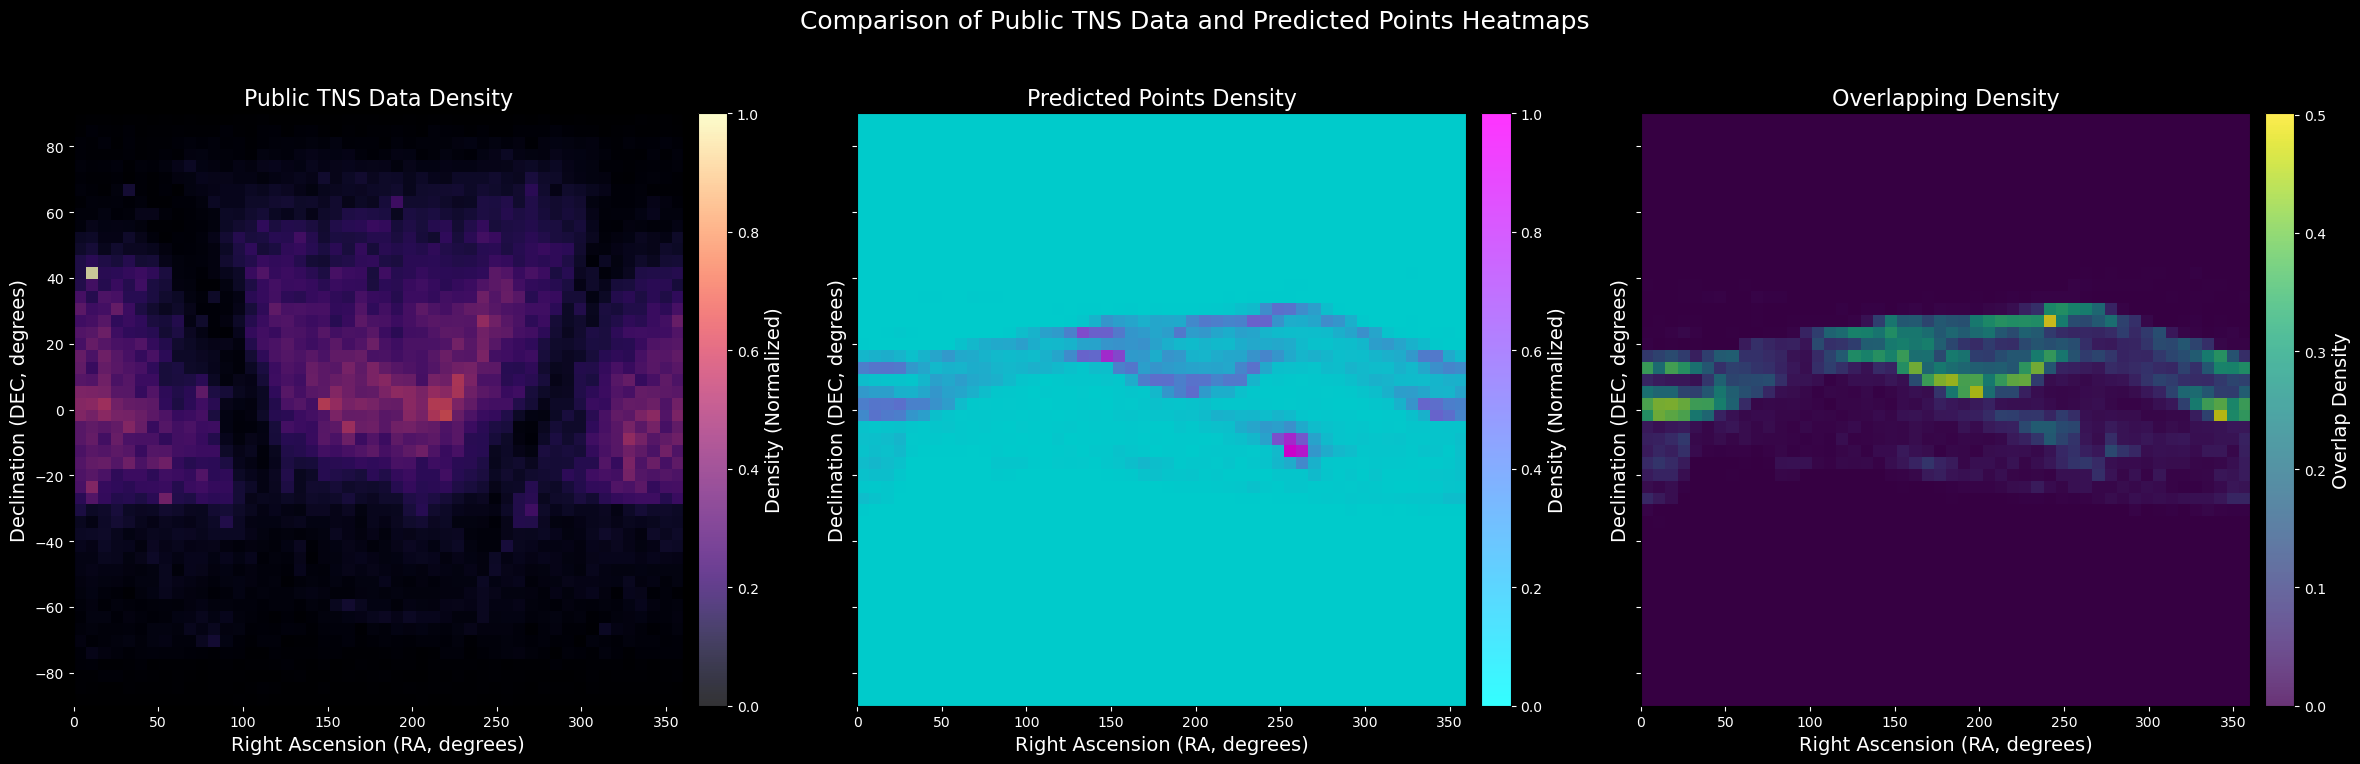

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# -----------------------------
# 1. Load the Public TNS Data
# -----------------------------
file_path = 'tns_public_objects.xlsx'
tns_data = pd.read_excel(file_path)

# Filter for objects with valid RA and DEC
tns_data_filtered = tns_data.dropna(subset=['ra', 'declination'])

# Extract RA and DEC values
public_ra = tns_data_filtered['ra'].values
public_dec = tns_data_filtered['declination'].values

# -----------------------------
# 2. Load the Predicted Points Data
# -----------------------------
future_predicted_path = 'future_predicted_points.csv'
predicted_points = pd.read_csv(future_predicted_path)

# Filter for valid RA and DEC in predicted data
predicted_points_filtered = predicted_points.dropna(subset=['RA (degrees)', 'DEC (degrees)'])

# Extract RA and DEC values
predicted_ra = predicted_points_filtered['RA (degrees)'].values
predicted_dec = predicted_points_filtered['DEC (degrees)'].values

# -----------------------------
# 3. Create 2D Histograms for Both Datasets
# -----------------------------

# Define bins and range
bins = (50, 50)
range_ = [[0, 360], [-90, 90]]

# Create 2D histogram for public data
heatmap_public, xedges_public, yedges_public = np.histogram2d(public_ra, public_dec, bins=bins, range=range_)
heatmap_public_normalized = heatmap_public.T / heatmap_public.max()

# Create 2D histogram for predicted data
heatmap_pred, xedges_pred, yedges_pred = np.histogram2d(predicted_ra, predicted_dec, bins=bins, range=range_)
heatmap_pred_normalized = heatmap_pred.T / heatmap_pred.max()

# -----------------------------
# 4. Compute Overlapping Densities
# -----------------------------

# Compute overlapping densities by taking the element-wise minimum
overlap_heatmap = np.minimum(heatmap_public_normalized, heatmap_pred_normalized)

# -----------------------------
# 5. Plot the Heatmaps
# -----------------------------

# Define the figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
fig.patch.set_facecolor('black')
for ax in axs:
    ax.set_facecolor('black')

# Define extent for imshow
extent = [xedges_public[0], xedges_public[-1], yedges_public[0], yedges_public[-1]]

# Define colormaps
cmap_public = sns.color_palette("magma", as_cmap=True)
cmap_pred = sns.color_palette("cool", as_cmap=True)
cmap_overlap = sns.color_palette("viridis", as_cmap=True)

# Plot public data heatmap
im_public = axs[0].imshow(heatmap_public_normalized, extent=extent, origin='lower', cmap=cmap_public, alpha=0.8, aspect='auto')
axs[0].set_title('Public TNS Data Density', fontsize=16, color='white')
axs[0].set_xlabel('Right Ascension (RA, degrees)', fontsize=14, color='white')
axs[0].set_ylabel('Declination (DEC, degrees)', fontsize=14, color='white')

# Plot predicted data heatmap
im_pred = axs[1].imshow(heatmap_pred_normalized, extent=extent, origin='lower', cmap=cmap_pred, alpha=0.8, aspect='auto')
axs[1].set_title('Predicted Points Density', fontsize=16, color='white')
axs[1].set_xlabel('Right Ascension (RA, degrees)', fontsize=14, color='white')
axs[1].set_ylabel('Declination (DEC, degrees)', fontsize=14, color='white')

# Plot overlap heatmap
im_overlap = axs[2].imshow(overlap_heatmap, extent=extent, origin='lower', cmap=cmap_overlap, alpha=0.8, aspect='auto')
axs[2].set_title('Overlapping Density', fontsize=16, color='white')
axs[2].set_xlabel('Right Ascension (RA, degrees)', fontsize=14, color='white')
axs[2].set_ylabel('Declination (DEC, degrees)', fontsize=14, color='white')

# Add colorbars
cbar_pub = plt.colorbar(im_public, ax=axs[0], orientation='vertical', pad=0.02)
cbar_pub.set_label('Density (Normalized)', color='white', fontsize=14)
cbar_pub.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar_pub.ax.yaxis.get_ticklabels(), color='white')

cbar_pred = plt.colorbar(im_pred, ax=axs[1], orientation='vertical', pad=0.02)
cbar_pred.set_label('Density (Normalized)', color='white', fontsize=14)
cbar_pred.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar_pred.ax.yaxis.get_ticklabels(), color='white')

cbar_overlap = plt.colorbar(im_overlap, ax=axs[2], orientation='vertical', pad=0.02)
cbar_overlap.set_label('Overlap Density', color='white', fontsize=14)
cbar_overlap.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar_overlap.ax.yaxis.get_ticklabels(), color='white')

# Adjust tick colors
for ax in axs:
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

# Add overall title
plt.suptitle("Comparison of Public TNS Data and Predicted Points Heatmaps", fontsize=18, color='white')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
